In [181]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [182]:
resolution = 100
nfreq = 100

# 파장 범위 설정 (단위: μm)
lambda_min = 0.4002
lambda_max = 0.7005

fmin = 1 / lambda_max
fmax = 1 / lambda_min

# fcen = 0.5 * (fmin + fmax)

# df = fmax - fmin

fcen = 1.75
df = 3.3

In [183]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000018
Iteration   1, error: 0.000212
Iteration   2, error: 0.000022
Iteration   3, error: 0.000010
Iteration   4, error: 0.000010
Iteration   5, error: 0.000006
Iteration   6, error: 0.000058
Iteration   7, error: 0.000015
Iteration   8, error: 0.000023
Iteration   9, error: 0.000021
Iteration  10, error: 0.000030
Iteration  11, error: 0.000016
Iteration  12, error: 0.000020
Iteration  13, error: 0.000017
Iteration  14, error: 0.000011
Iteration  15, error: 0.000008
Iteration  16, error: 0.000011
Iteration  17, error: 0.000006
Iteration  18, error: 0.000008
Iteration  19, error: 0.000015
Iteration  20, error: 0.000003
Iteration  21, error: 0.000018
Iteration  22, error: 0.000005
Iteration  23, error: 0.000014
Iteration  24, error: 0.000059
Iteration  25, error: 0.000120
Iteration  26, error: 0.000015
Iteration  27, error: 0.000009
Iteration  28, error: 0.000035
Iteration  29, error: 0.000011
Optimal error: 0.000003
Iteration   0, error: 3.131232
Iteration   1, 

In [184]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [185]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [186]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [187]:
pml_layer = 0.3

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
    
]

In [188]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, -0.85, 0),
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, -0.67, 0),
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, -0.615, 0),
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, -0.515, 0),
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, -0.405, 0),
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, 0.315, 0),
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [189]:
cell_size = mp.Vector3(30, 2, 0)

In [ ]:
source_center = mp.Vector3(0,-0.67,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

In [ ]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

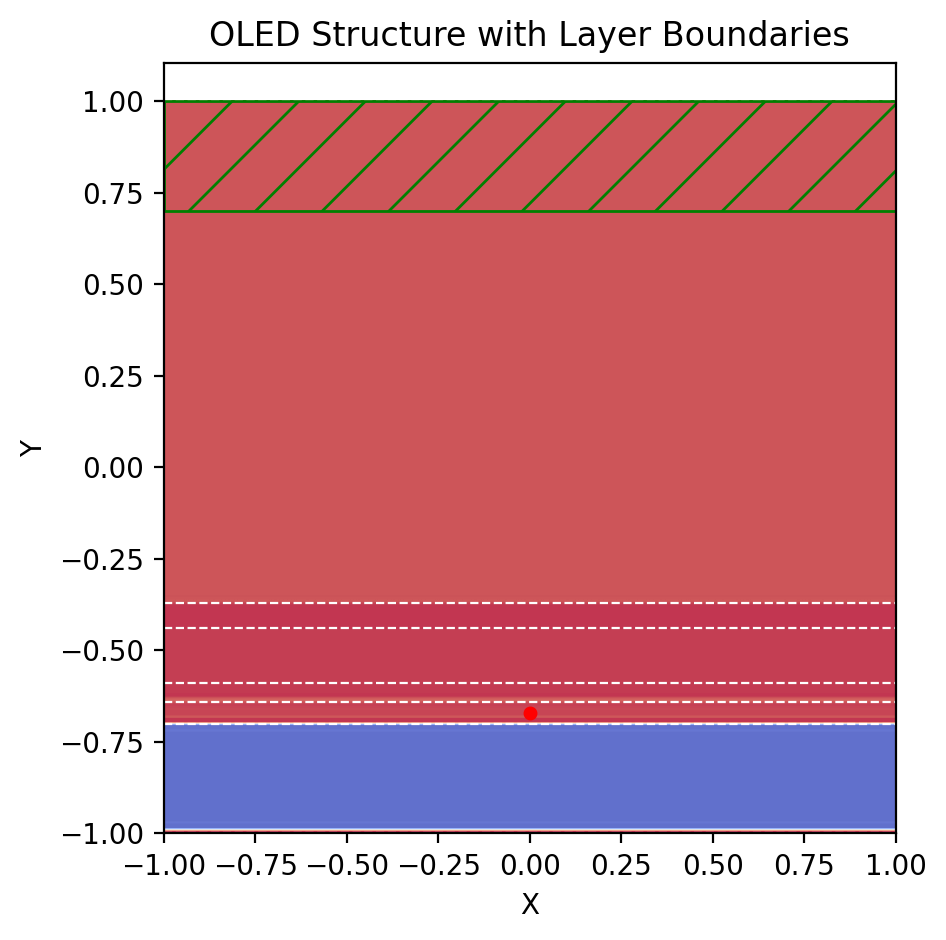

In [216]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()

가우시안에 대한 필드 분포 뽑기

In [217]:
# --- Flux 모니터 4면 등록 (tight box 기준) ---
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

# 박스 4면
box_power = sim.add_flux(
    fcen, df, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

/home/min/miniconda3/envs/mp/lib/python3.8/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


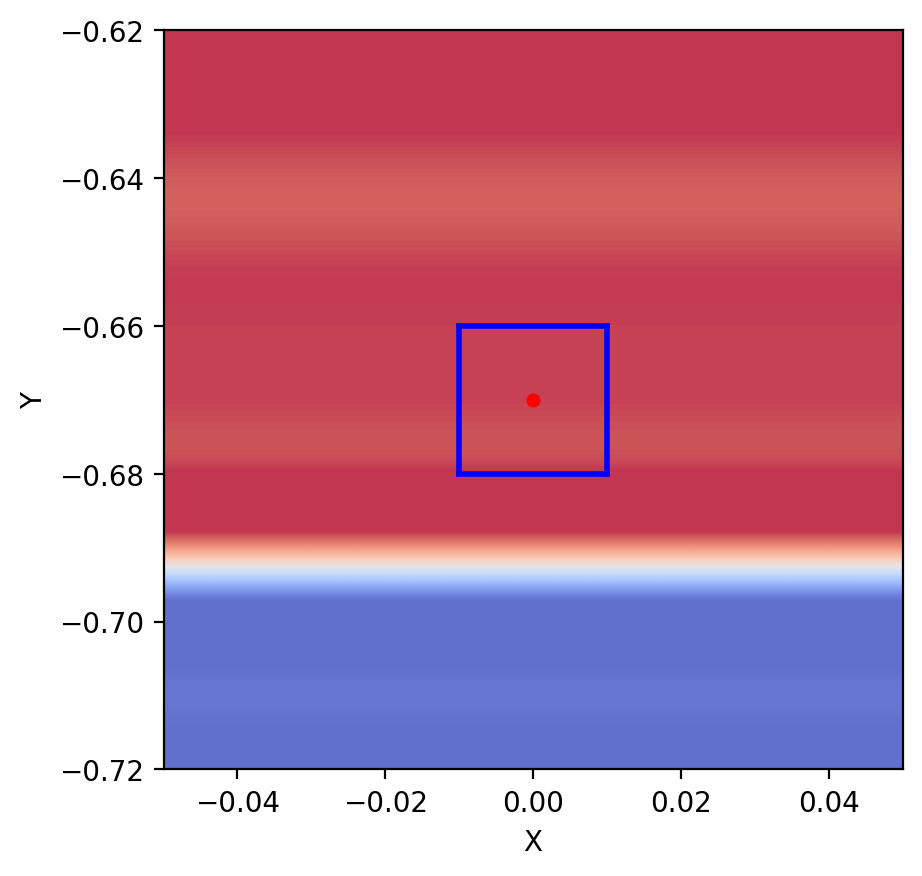

In [218]:
# center와 size를 사용해 Volume 객체 생성
vol = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 2, 0))
fig = plt.figure(dpi=200)
ax = plt.gca()

# 그 volume을 사용해서 2D 시각화
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,-0.67,0), size=mp.Vector3(0.1, 0.1, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)
plt.show()

In [213]:
mp.verbosity(0)
sim.run(until=50)
net_power = mp.get_fluxes(box_power)


In [198]:
frequencies = mp.get_flux_freqs(box_power)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{net_power[i]:.6e}")

λ (μm)		dipolepower_box (W)
10.0000		-2.122512e-09
7.5000		-5.599208e-09
6.0000		-6.087584e-09
5.0000		4.724925e-09
4.2857		1.292890e-08
3.7500		5.921553e-08
3.3333		1.391386e-07
3.0000		2.870115e-07
2.7273		5.949677e-07
2.5000		1.091229e-06
2.3077		1.982643e-06
2.1429		3.466089e-06
2.0000		5.823755e-06
1.8750		9.654233e-06
1.7647		1.551661e-05
1.6667		2.447637e-05
1.5789		3.793367e-05
1.5000		5.753534e-05
1.4286		8.592428e-05
1.3636		1.259444e-04
1.3043		1.814099e-04
1.2500		2.572709e-04
1.2000		3.589275e-04
1.1538		4.939514e-04
1.1111		6.709791e-04
1.0714		9.004040e-04
1.0345		1.195574e-03
1.0000		1.570814e-03
0.9677		2.043952e-03
0.9375		2.634997e-03
0.9091		3.365283e-03
0.8824		4.259815e-03
0.8571		5.342848e-03
0.8333		6.639518e-03
0.8108		8.174294e-03
0.7895		9.966266e-03
0.7692		1.203250e-02
0.7500		1.438194e-02
0.7317		1.701555e-02
0.7143		1.992983e-02
0.6977		2.310426e-02
0.6818		2.651474e-02
0.6667		3.012596e-02
0.6522		3.389070e-02
0.6383		3.775614e-02
0.6250		4.165798e-02
0.

In [ ]:
offset = 0.01
flux_size = 0.02
source_center = mp.Vector3(0, -0.67, 0)

dft_monitor = sim.add_dft_fields(
    [mp.Ey],                # 원하는 필드 컴포넌트 (여기선 Ey)
    fcen - df/2,            # 시작 주파수
    df,                     # 대역폭
    nfreq,                  # 주파수 수
    where=mp.Volume(
        center=source_center,
        size=mp.Vector3(flux_size + 2 * offset, flux_size + 2 * offset, 0)
    )
)



TypeError: __init__() missing 2 required positional arguments: 'components' and 'volumes'

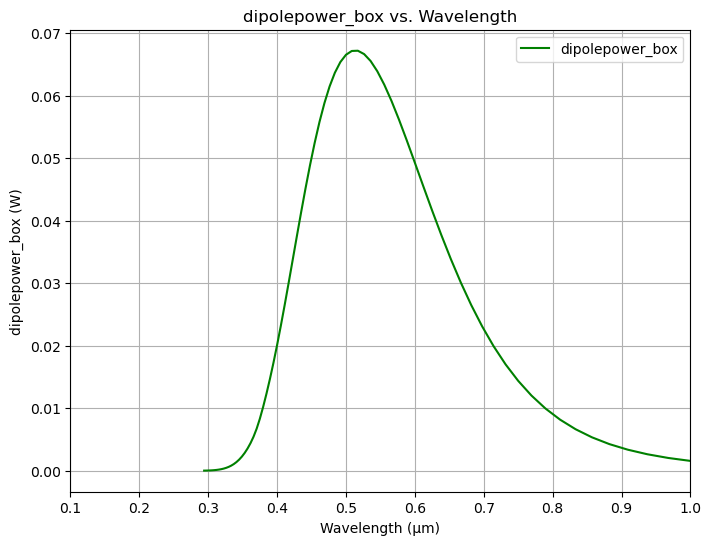

In [201]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power, '-', label='dipolepower_box', color = 'green')
plt.xlabel('Wavelength (μm)')
plt.ylabel('dipolepower_box (W)')
plt.title('dipolepower_box vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14
plt.xlim([0.1, 1])
plt.legend()
plt.grid(True)
plt.show()

In [202]:
import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",", skip_header=1)

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths >= 0) & (wavelengths <= 10)
wavelength_sliced = wavelengths
power_sliced = source_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [10.          7.5         6.          5.          4.28571429  3.75
  3.33333333  3.          2.72727273  2.5         2.30769231  2.14285714
  2.          1.875       1.76470588  1.66666667  1.57894737  1.5
  1.42857143  1.36363636  1.30434783  1.25        1.2         1.15384615
  1.11111111  1.07142857  1.03448276  1.          0.96774194  0.9375
  0.90909091  0.88235294  0.85714286  0.83333333  0.81081081  0.78947368
  0.76923077  0.75        0.73170732  0.71428571  0.69767442  0.68181818
  0.66666667  0.65217391  0.63829787  0.625       0.6122449   0.6
  0.58823529  0.57692308  0.56603774  0.55555556  0.54545455  0.53571429
  0.52631579  0.51724138  0.50847458  0.5         0.49180328  0.48387097
  0.47619048  0.46875     0.46153846  0.45454545  0.44776119  0.44117647
  0.43478261  0.42857143  0.42253521  0.41666667  0.4109589   0.40540541
  0.4         0.39473684  0.38961039  0.38461538  0.37974684  0.375
  0.37037037  0.36585366  0.36144578  0.35714286  0.35294118  

TypeError: 'list' object is not callable

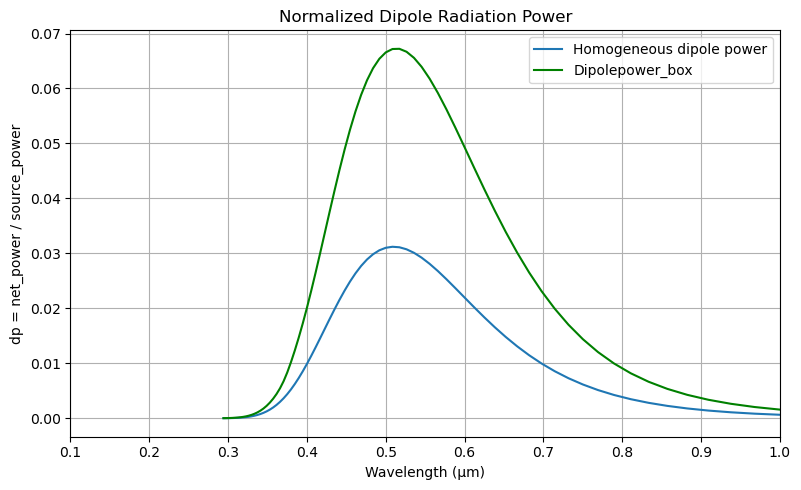

In [206]:
source_power_interp = np.interp(wavelength_sliced, wavelengths, source_power)

# dp = net_power / source_power

# 5. Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, source_power, '-', label='Homogeneous dipole power', )
# plt.plot(wavelengths, dp,  label='Normalized pipole power (dp)', color='blue')
plt.plot(wavelengths, net_power, '-', label='Dipolepower_box', color = 'green')

plt.xlabel("Wavelength (μm)")
plt.ylabel("dp = net_power / source_power")
plt.title("Normalized Dipole Radiation Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.yscale("log")

# plt.ylim([-4, 14])
plt.xlim([0.1, 1])
plt.show()

sim.add_flux(...) → Fourier-transformed field 데이터를 누적 시작

sim.get_fluxes(flux_obj) → 누적된 데이터를 바탕으로 power 계산

sim.get_dft_array(...) → 실제 E, H field의 Fourier transformed 값을 배열로 받을 수 있음

→ 파장이 길어질수록 source dipole의 방사효율은 줄어들지만, 시스템은 에너지를 더 잘 전달함 → dp 증가.

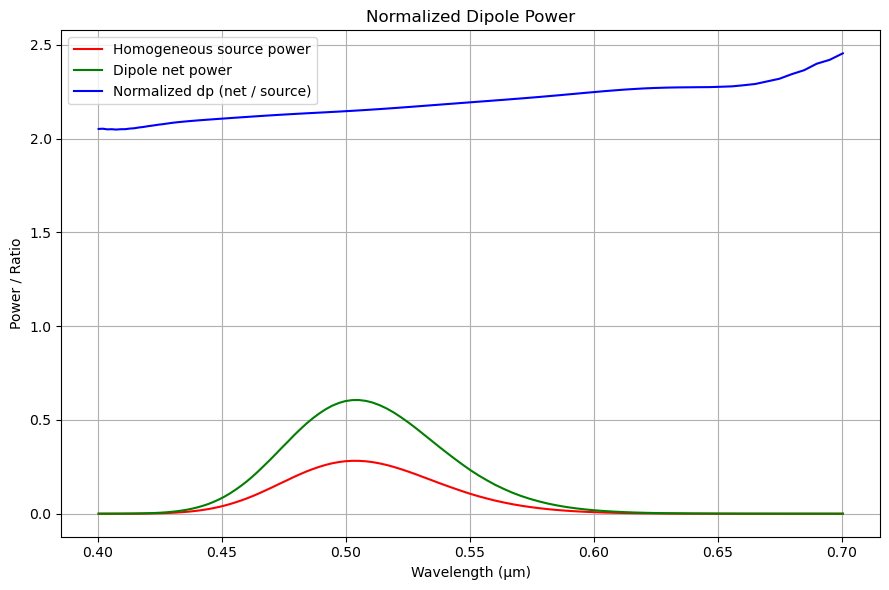

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# 1. wavelength (공통)
wavelengths = np.array([
    0.7005, 0.6952, 0.6900, 0.6849, 0.6799, 0.6749, 0.6700, 0.6652, 0.6605, 0.6558,
    0.6511, 0.6466, 0.6421, 0.6377, 0.6333, 0.6290, 0.6247, 0.6205, 0.6164, 0.6123,
    0.6083, 0.6043, 0.6004, 0.5965, 0.5927, 0.5889, 0.5852, 0.5815, 0.5779, 0.5743,
    0.5707, 0.5672, 0.5638, 0.5603, 0.5570, 0.5536, 0.5503, 0.5471, 0.5439, 0.5407,
    0.5375, 0.5344, 0.5313, 0.5283, 0.5253, 0.5223, 0.5194, 0.5165, 0.5136, 0.5108,
    0.5080, 0.5052, 0.5025, 0.4997, 0.4971, 0.4944, 0.4918, 0.4892, 0.4866, 0.4840,
    0.4815, 0.4790, 0.4766, 0.4741, 0.4717, 0.4693, 0.4669, 0.4646, 0.4623, 0.4600,
    0.4577, 0.4554, 0.4532, 0.4510, 0.4488, 0.4466, 0.4445, 0.4423, 0.4402, 0.4381,
    0.4361, 0.4340, 0.4320, 0.4300, 0.4280, 0.4260, 0.4241, 0.4221, 0.4202, 0.4183,
    0.4164, 0.4146, 0.4127, 0.4109, 0.4091, 0.4073, 0.4055, 0.4037, 0.4019, 0.4002
])

# 2. net power
net_power = np.array([
    1.285025e-05, 1.949239e-05, 2.927119e-05, 4.364822e-05, 6.449488e-05,
    9.459167e-05, 1.375375e-04, 1.984399e-04, 2.839074e-04, 4.029687e-04,
    5.672194e-04, 7.919821e-04, 1.096695e-03, 1.506271e-03, 2.051818e-03,
    2.772058e-03, 3.714443e-03, 4.936354e-03, 6.506627e-03, 8.506043e-03,
    1.102921e-02, 1.418365e-02, 1.809190e-02, 2.288826e-02, 2.872101e-02,
    3.574577e-02, 4.412777e-02, 5.403093e-02, 6.562032e-02, 7.904629e-02,
    9.444787e-02, 1.119319e-01, 1.315783e-01, 1.534155e-01, 1.774289e-01,
    2.035338e-01, 2.315905e-01, 2.613755e-01, 2.926056e-01, 3.249101e-01,
    3.578649e-01, 3.909677e-01, 4.236817e-01, 4.554150e-01, 4.855721e-01,
    5.135364e-01, 5.387272e-01, 5.605827e-01, 5.786174e-01, 5.924036e-01,
    6.016238e-01, 6.060482e-01, 6.055776e-01, 6.002151e-01, 5.900965e-01,
    5.754564e-01, 5.566453e-01, 5.340920e-01, 5.083088e-01, 4.798530e-01,
    4.493240e-01, 4.173282e-01, 3.844709e-01, 3.513287e-01, 3.184407e-01,
    2.862901e-01, 2.552973e-01, 2.258126e-01, 1.981117e-01, 1.723987e-01,
    1.488046e-01, 1.273977e-01, 1.081841e-01, 9.112337e-02, 7.612922e-02,
    6.308690e-02, 5.185373e-02, 4.227562e-02, 3.418606e-02, 2.742087e-02,
    2.181503e-02, 1.721519e-02, 1.347402e-02, 1.046130e-02, 8.052671e-03,
    6.150423e-03, 4.660056e-03, 3.501944e-03, 2.610362e-03, 1.930052e-03,
    1.415454e-03, 1.029722e-03, 7.429953e-04, 5.318211e-04, 3.775391e-04,
    2.658786e-04, 1.856871e-04, 1.286506e-04, 8.838119e-05, 6.023383e-05
])

# 3. source power
source_power = np.array([
    5.235750e-06, 8.055623e-06, 1.220064e-05, 1.845975e-05, 2.752246e-05,
    4.079269e-05, 5.967359e-05, 8.661311e-05, 1.242860e-04, 1.768702e-04,
    2.492034e-04, 3.482369e-04, 4.823048e-04, 6.626138e-04, 9.028367e-04,
    1.220359e-03, 1.636496e-03, 2.177032e-03, 2.873457e-03, 3.762099e-03,
    4.886890e-03, 6.296151e-03, 8.047511e-03, 1.020116e-02, 1.282773e-02,
    1.599661e-02, 1.978773e-02, 2.427361e-02, 2.953607e-02, 3.564069e-02,
    4.265981e-02, 5.063829e-02, 5.962427e-02, 6.962568e-02, 8.065025e-02,
    9.265279e-02, 1.055858e-01, 1.193384e-01, 1.337982e-01, 1.487837e-01,
    1.641174e-01, 1.795527e-01, 1.948587e-01, 2.097425e-01, 2.239434e-01,
    2.371531e-01, 2.491144e-01, 2.595418e-01, 2.682200e-01, 2.749246e-01,
    2.795173e-01, 2.818673e-01, 2.819372e-01, 2.797078e-01, 2.752512e-01,
    2.686603e-01, 2.601070e-01, 2.497791e-01, 2.379229e-01, 2.247903e-01,
    2.106669e-01, 1.958308e-01, 1.805689e-01, 1.651483e-01, 1.498234e-01,
    1.348206e-01, 1.203379e-01, 1.065417e-01, 9.356179e-02, 8.149838e-02,
    7.041291e-02, 6.034322e-02, 5.129184e-02, 4.324598e-02, 3.616419e-02,
    2.999851e-02, 2.468028e-02, 2.014218e-02, 1.630378e-02, 1.309189e-02,
    1.042649e-02, 8.238348e-03, 6.455885e-03, 5.019693e-03, 3.870720e-03,
    2.961778e-03, 2.247314e-03, 1.692222e-03, 1.263352e-03, 9.360593e-04,
    6.874411e-04, 5.010806e-04, 3.618812e-04, 2.594241e-04, 1.841780e-04,
    1.298240e-04, 9.058239e-05, 6.278443e-05, 4.305834e-05, 2.936470e-05
])

# 4. 정규화 (dp 계산)
dp = net_power / source_power

# 5. Plot
plt.figure(figsize=(9, 6))
plt.plot(wavelengths, source_power, label='Homogeneous source power', color='red')
plt.plot(wavelengths, net_power, label='Dipole net power', color='green')
plt.plot(wavelengths, dp, label='Normalized dp (net / source)', color='blue')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power / Ratio")
plt.title("Normalized Dipole Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
